# Results for instance 3

This notebook shows the results over the previously experiments done

In [1]:
import json
import os
import matplotlib.pyplot as plt
from openqaoa.algorithms import QAOAResult
from openqaoa.qaoa_components import Hamiltonian,PauliOp
import numpy as np

## Upload json files

In [2]:
results = []
file_names=['cpu_statevector','gpu_statevector']

for file_name in file_names:
    file_route = os.path.join('./',file_name+'.json')
    with open(file_route, "r") as file:
        result = json.load(file)
        #print(result)
        #result = QAOAResult.from_dict(result)
        results.append(result)

In [144]:
#results[0]

This is an important step. The data imported is in json format. For using the multiple analysis functions that OpenQAOA, we need to create the respective objects with the dict. For that we should:

1. Create the PauliOp objects for each cost hamiltonian
2. Once we have the PauliOp objects, we create each Hamiltonian object
3. Once we have the Hamiltonian object, we create the QAOAResult obejct

In [3]:
maxfevs=['100','250','500','750','1000']
for itr,result in enumerate(results):
    for maxfev in maxfevs:
        # get the QAOA result as dict
        result_dict = results[itr]['maxfev '+maxfev]['result']

        # get cost hamiltonian as dict
        hamiltonian_dict = result_dict['cost_hamiltonian']

        # for each pauliOp represented as dict, convert it to an object
        for itr2,pauliOp_dict in enumerate(hamiltonian_dict['terms']):
            qubit_indices = pauliOp_dict['qubit_indices']
            pauli_str = pauliOp_dict['pauli_str']

            hamiltonian_dict['terms'][itr2] = PauliOp(pauli_str,qubit_indices)

        # now that we have PauliOp objects, we can create the Hamiltonian object for the cost hamiltonian
        result_dict['cost_hamiltonian'] = Hamiltonian(hamiltonian_dict['terms'],hamiltonian_dict['coeffs'],hamiltonian_dict['constant']) 

        # now that we have the Hamiltonian object, we can create que QAOAResult object
        results[itr]['maxfev '+maxfev]['result'] = QAOAResult.from_dict(result_dict)

One that we have the QAOAResult object, we can make use of a useful function called  $\texttt{lowest\_cost\_bitstrings(n)}$ . This return the $n$ most approximates solutions found by the QAOA optimization. For each one, it show the respective bitstring, its energy(cost) and it occurance probability.

Here, it is important to notice that, if the QAOA is not correctly configured, $\textbf{the most approximates solutions found will be bad solutions by nature}$. Remember that this function just analyze the solutions found by the QAOA optimization, not the whole search space. That means, if an optimal solution is not found by the QAOA optimization, this function will not show it.

For this notebook, we will took the 10 most approximates solutions found.

In [4]:
lowest_cost_bitstrings = []
for itr,result in enumerate(results):
    lowest_cost_bitstrings.append([])
    for maxfev in maxfevs:
        #lowest_cost_bitstrings = result['maxfev '+maxfev]['result'].lowest_cost_bitstrings(10)
       # probabilities.append(
        #    lowest_cost_bitstrings
       # )
        lowest_cost_bitstrings[itr].append(result['maxfev '+maxfev]['result'].lowest_cost_bitstrings(10))

In [5]:
lowest_cost_bitstrings

[[{'solutions_bitstrings': ['0000001000000001000000000',
    '0000010000000000100000000',
    '0000001000000000001000000',
    '0000001000000001000000010',
    '0000001000000000000000000',
    '0000001000000000001010000',
    '0000001000000000000100000',
    '0000001000000000010000000',
    '0000001000000000000010000',
    '0000001000000000000110000'],
   'bitstrings_energies': [-2.8200000000000074,
    -2.4299999999999926,
    -2.1400000000000006,
    -2.010000000000005,
    -2.010000000000005,
    -1.9999999999999858,
    -1.9899999999999949,
    -1.980000000000004,
    -1.8699999999999903,
    -1.84999999999998],
   'probabilities': [0.0377,
    0.0189,
    0.0103,
    0.0016,
    0.0215,
    0.003,
    0.008,
    0.0106,
    0.0053,
    0.0028]},
  {'solutions_bitstrings': ['0000001000000001000000000',
    '0000010000000000100000000',
    '0000001000000000001000000',
    '0000001000000000000000000',
    '0000001000000001000000010',
    '0000001000000000001010000',
    '000000100000

## Execution time comparison

This will show a function for each execution running. Each execution running is formed by the different maxfevs for which it was run.

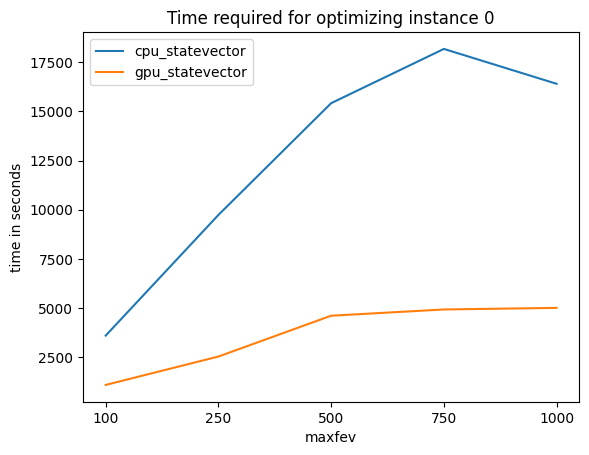

In [6]:
times = []

for itr,result in enumerate(results):
    times.append([])
    for maxfev in maxfevs:
        times[itr].append(result['maxfev '+maxfev]['time'])

# write the functions
for itr,time in enumerate(times):
    plt.plot(maxfevs, time, label=file_names[itr])

# peronalize labels
plt.xlabel('maxfev')
plt.ylabel('time in seconds')
plt.title('Time required for optimizing instance 3')
plt.legend()

plt.show()

ESCRIBIR ANALISIS

## approximate solutions probabilities comparison

For each execution running and maxfev, we will show the sum of ocurrance probabilities for the 10 most approximate solutions found.

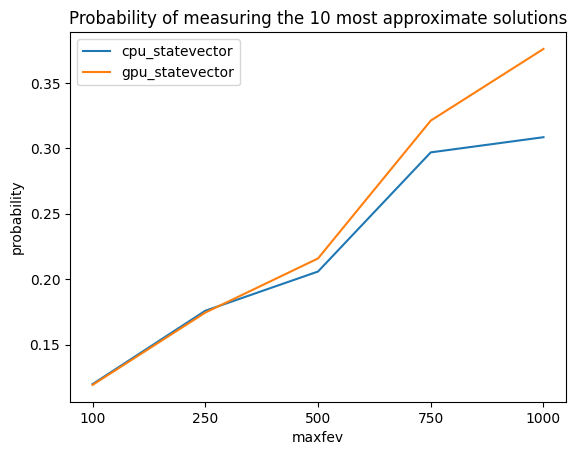

In [7]:
probabilities = []
for itr,problem in enumerate(lowest_cost_bitstrings):
    probabilities.append([])
    for lcb in problem:
        probabilities[itr].append(sum(lcb['probabilities']))

for itr,probs in enumerate(probabilities):
    plt.plot(maxfevs, probs, label=file_names[itr])

# peronalize labels
plt.xlabel('maxfev')
plt.ylabel('probability')
plt.title('Probability of measuring the 10 most approximate solutions')
plt.legend()

plt.show()

In some way, a better probability performance trough giving more maxfevs can be seen. Of course, because QC is probabilitic, some stochastic behaviour is seen. But, in general terms, the occurance probability is logical.

## Are all approximate solutions found feasible?

The next cell analyze for each (execution running,maxfev) if all the solutions found are feasible.

In [8]:
def is_feasible(bitstring):
    num_vacnJobs = 5
    
    for itr in range(0,len(bitstring),num_vacnJobs):
        sum = 0
        for i in range(itr,itr+num_vacnJobs):
            #print(bitstring[i])
            sum += int(bitstring[i])
        #print('res=',sum)
        if sum > 1:
            #print('sale')
            return False
    return True

for itr,problem in enumerate(lowest_cost_bitstrings):
    for itr2,lcb in enumerate(problem):
        feasible = True
        total_feasible_solutions = 0
        for solution_bitstring in lcb['solutions_bitstrings']:
            feasible = is_feasible(solution_bitstring)
            print('is_feasible(',file_names[itr],',',maxfevs[itr2],',',solution_bitstring,'):',feasible)
            if feasible:
                total_feasible_solutions += 1
        print('TOTAL FEASIBLE SOLUTIONS: ',total_feasible_solutions,'/10\n')

is_feasible( cpu_statevector , 100 , 0000001000000001000000000 ): True
is_feasible( cpu_statevector , 100 , 0000010000000000100000000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000001000000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000001000000010 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000000000000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000001010000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000000100000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000010000000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000000010000 ): True
is_feasible( cpu_statevector , 100 , 0000001000000000000110000 ): True
TOTAL FEASIBLE SOLUTIONS:  10 /10

is_feasible( cpu_statevector , 250 , 0000001000000001000000000 ): True
is_feasible( cpu_statevector , 250 , 0000010000000000100000000 ): True
is_feasible( cpu_statevector , 250 , 0000001000000000001000000 ): True
is_feasible( cpu_statevector , 250 , 00000

## Cost histories comparison

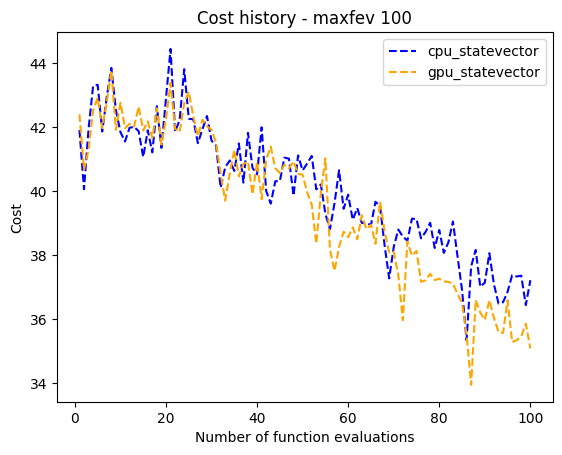

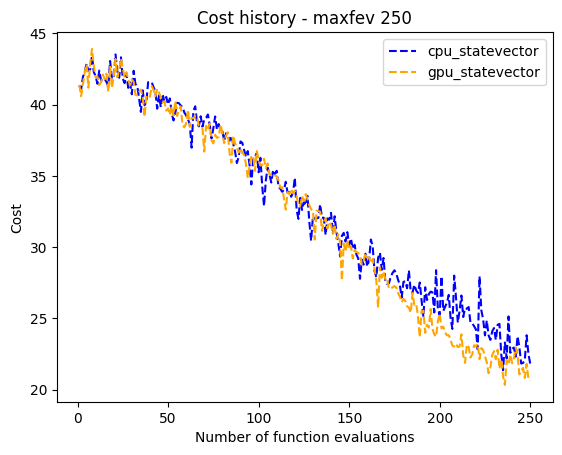

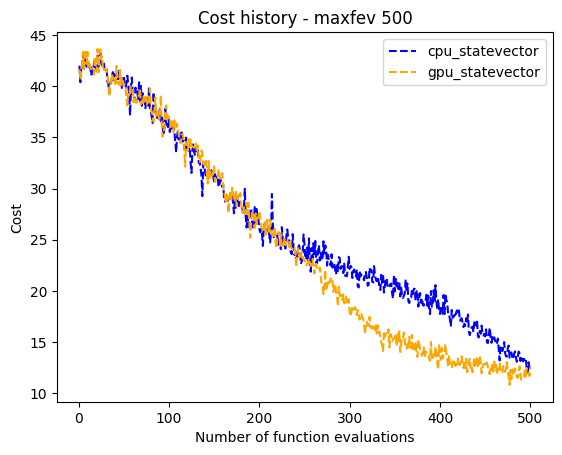

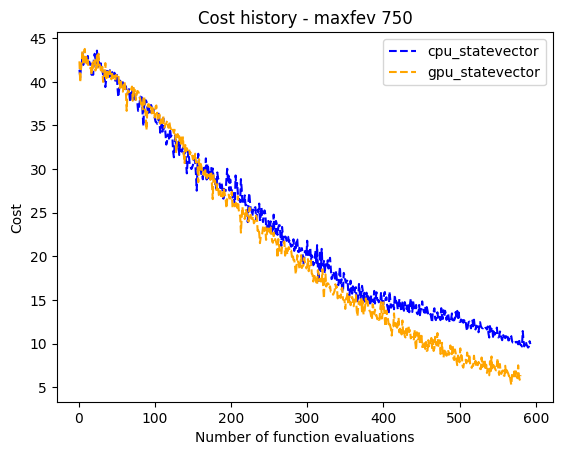

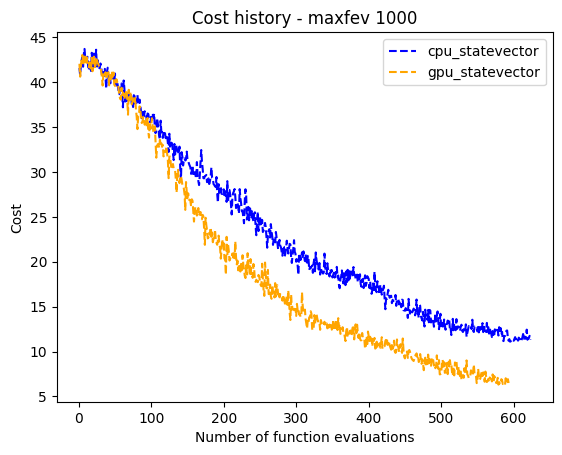

In [9]:
for maxfev in maxfevs:
    fig, ax = plt.subplots()
    results[0]['maxfev '+maxfev]['result'].plot_cost(label='cpu_statevector',ax=ax)
    results[1]['maxfev '+maxfev]['result'].plot_cost(label='gpu_statevector',color='orange',ax=ax)
    ax.set_title('Cost history - maxfev '+maxfev)